In [1]:
import os
import shutil
from pathlib import Path
import random

# Base paths
SOURCE_PATH = Path("../dataset/real_and_fake_face")
CLASSES = ['training_real', 'training_fake']
TARGET_PATH = Path("../dataset/real_and_fake_face_split")

# Split ratios
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

# Create target folders
for split in ['train', 'val', 'test']:
    for label in CLASSES:
        (TARGET_PATH / split / label).mkdir(parents=True, exist_ok=True)

# Distribute files
for label in CLASSES:
    source_folder = SOURCE_PATH / label
    files = [f for f in source_folder.glob("*") if f.is_file()]
    random.shuffle(files)

    total = len(files)
    train_end = int(total * TRAIN_RATIO)
    val_end = train_end + int(total * VAL_RATIO)

    # Copy to train
    for file in files[:train_end]:
        shutil.copy(file, TARGET_PATH / "train" / label / file.name)

    # Copy to val
    for file in files[train_end:val_end]:
        shutil.copy(file, TARGET_PATH / "val" / label / file.name)

    # Copy to test
    for file in files[val_end:]:
        shutil.copy(file, TARGET_PATH / "test" / label / file.name)

print("✅ Dataset successfully split into train, val, and test!")

✅ Dataset successfully split into train, val, and test!


In [2]:
import tensorflow as tf

# 📁 Path to your split dataset
BASE_PATH = "../dataset/real_and_fake_face_split"
IMG_SIZE = (299, 299)
BATCH_SIZE = 32

# 🔄 Load training data
train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_PATH + "/train",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# 🔄 Load validation data
val_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_PATH + "/val",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# 🔄 Load test data
test_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_PATH + "/test",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# 🏷️ Optional: Confirm class names
class_names = ['training_fake', 'training_real']

# ⚡ Enable prefetching and caching for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)

Found 8428 files belonging to 2 classes.
Found 2408 files belonging to 2 classes.
Found 1205 files belonging to 2 classes.


2025-06-26 23:32:48.851691: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-06-26 23:32:48.851739: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-06-26 23:32:48.851742: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-06-26 23:32:48.851763: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-26 23:32:48.851777: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Normalization layer
preprocessing_layer = tf.keras.layers.Rescaling(1./255)

# Load full Xception model without top layer
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)
)

# Unfreeze ALL layers
base_model.trainable = True

# Build the model
model = models.Sequential([
    preprocessing_layer,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),  # Increase from 0.3 to 0.5
    layers.Dense(128, activation='relu'),  # Add intermediate layer
    layers.Dropout(0.3),  # Another Dropout layer
    layers.Dense(1, activation='sigmoid')  # Binary output
])

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # low LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [5]:
EPOCHS = 30  # you can increase if needed

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/30


2025-06-26 23:33:07.922837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


264/264 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.5706 - loss: 0.6868 - val_accuracy: 0.7118 - val_loss: 0.5522
Epoch 2/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.7496 - loss: 0.5133 - val_accuracy: 0.8169 - val_loss: 0.4189
Epoch 3/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.8370 - loss: 0.3759 - val_accuracy: 0.8480 - val_loss: 0.3431
Epoch 4/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.8935 - loss: 0.2610 - val_accuracy: 0.8621 - val_loss: 0.3047
Epoch 5/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.9220 - loss: 0.1850 - val_accuracy: 0.8717 - val_loss: 0.2871
Epoch 6/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.9512 - loss: 0.1263 - val_accuracy: 0.8758 - val_loss: 0.2929
Epoch 7/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.9687 - loss: 0.0837 - val_accuracy: 0.8846 - val_loss: 0.3044
Epoch 8/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.9851 - loss: 0.0508 - val_accuracy: 0.883

In [6]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_PATH + "/test",
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# ✅ Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"✅ Final Test Accuracy: {test_accuracy:.4f}")
print(f"📉 Final Test Loss: {test_loss:.4f}")

Found 1205 files belonging to 2 classes.
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - accuracy: 0.8895 - loss: 0.7824
✅ Final Test Accuracy: 0.8988
📉 Final Test Loss: 0.6127


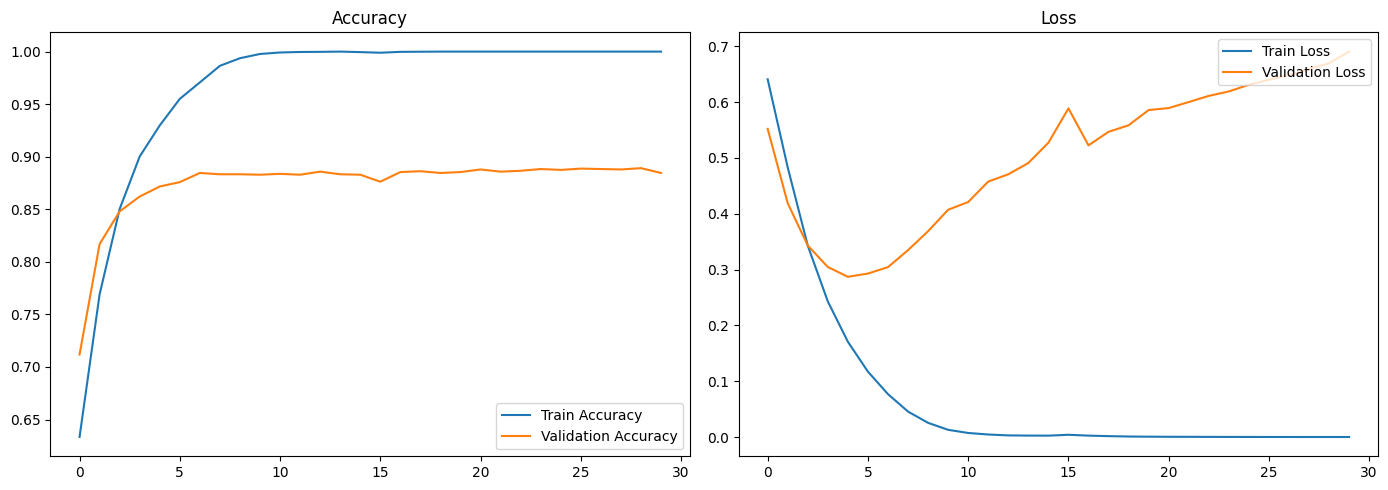

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')

plt.tight_layout()
plt.show()

2025-06-27 03:34:14.086356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.87      0.89       596
         1.0       0.88      0.93      0.90       609

    accuracy                           0.90      1205
   macro avg       0.90      0.90      0.90      1205
weighted avg       0.90      0.90      0.90      1205



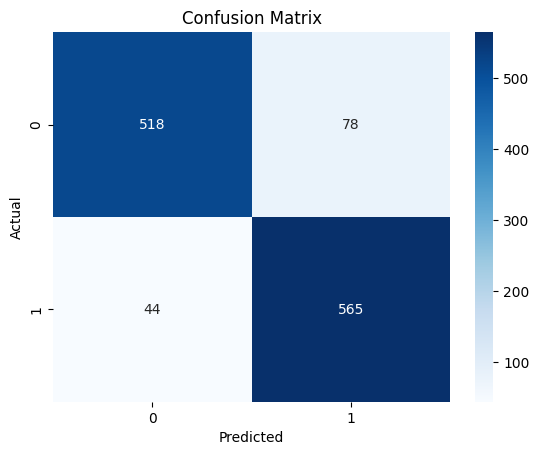

In [11]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get true labels and predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

2025-06-27 04:26:27.248717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step


/var/folders/l2/bd_pbzdx6pxgbw5s9mnb3pr80000gn/T/ipykernel_11488/55531606.py:33: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


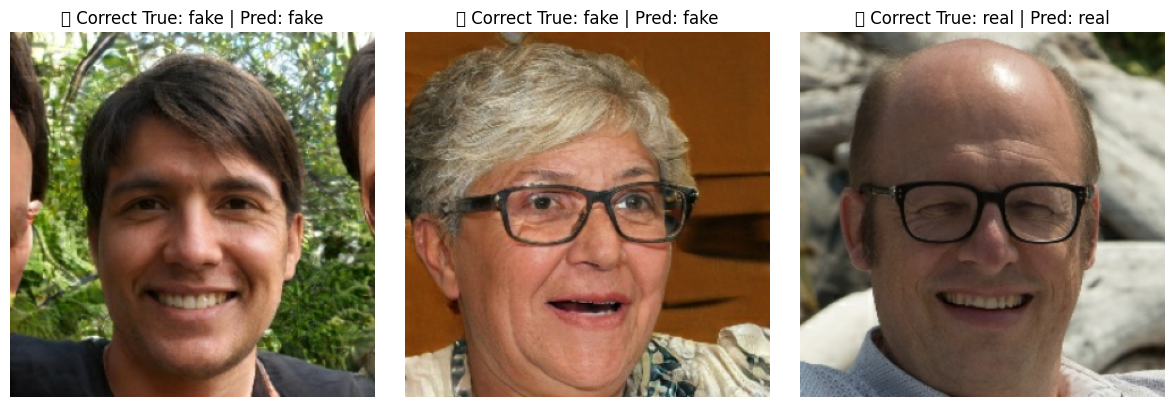

/var/folders/l2/bd_pbzdx6pxgbw5s9mnb3pr80000gn/T/ipykernel_11488/55531606.py:33: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


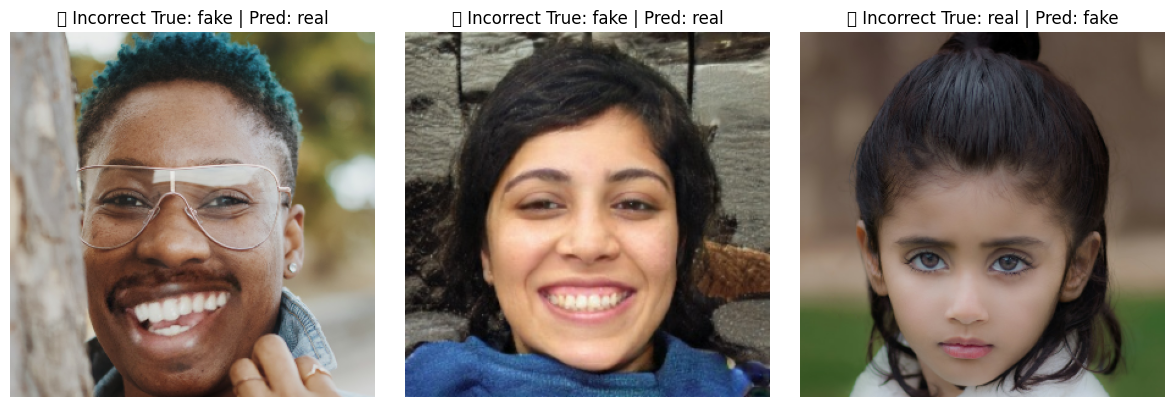

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Label mapping
class_names = ['fake', 'real']

# Get test data
test_images, test_labels = [], []
for images, labels in test_ds.unbatch().take(300):
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())
test_images = np.array(test_images)
test_labels = np.array(test_labels).flatten()

# Predict
pred_probs = model.predict(test_images)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# Indices
correct = np.where(pred_labels == test_labels)[0]
incorrect = np.where(pred_labels != test_labels)[0]

# Helper function to plot images
def plot_predictions(indices, title_prefix, emoji):
    plt.figure(figsize=(12, 4))
    for i, idx in enumerate(indices[:3]):
        plt.subplot(1, 3, i + 1)
        plt.imshow(test_images[idx] / 255.0)
        true_label = class_names[int(test_labels[idx])]
        pred_label = class_names[int(pred_labels[idx])]
        plt.title(f"{emoji} {title_prefix} True: {true_label} | Pred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Plot correct and incorrect
plot_predictions(correct, "Correct", "✅")
plot_predictions(incorrect, "Incorrect", "❌")

In [54]:
# Save the model in the recommended Keras format
model.save("xception_face_detector.keras")

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("xception_face_detector.keras")